
<h1 align="center"><font size="5">LOGISTIC REGRESSION WITH TENSORFLOW</font></h1>

-------------------------------

<a id="ref2"></a>
<h2>Utilizing Logistic Regression in TensorFlow</h2>

For us to utilize Logistic Regression in TensorFlow, we first need to import the required libraries. To do so, you can run the code cell below.

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

WARNING - From C:\Users\samen\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\compat\v2_compat.py:88: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


<h3>Understanding the Data</h3>

<h4><code>Iris Dataset</code>:</h4>
This dataset was introduced by British Statistician and Biologist Ronald Fisher, it consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). In total it has 150 records under five attributes - petal length, petal width, sepal length, sepal width and species. <a href="https://archive.ics.uci.edu/ml/datasets/iris">Dataset source</a>

Attributes
Independent Variable
<ul>
    <li>petal length</li>
    <li>petal width</li>
    <li>sepal length</li>
    <li>sepal width</li>
</ul>
Dependent Variable
<ul>    
    <li>Species
        <ul>
            <li>Iris setosa</li>
            <li>Iris virginica</li>
            <li>Iris versicolor</li>
        </ul>
    </li>
</ul>
<br>

In [5]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

In [6]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]

# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris has 4 features, so X is a tensor to hold our data.
yGold = tf.placeholder(tf.float32, [None, numLabels]) # This will be our correct answers matrix for 3 classes.

In [7]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [8]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))


<h3>Logistic Regression model</h3>

We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

However, for the sake of clarity, we can have it broken into its three main components: 
- a weight times features matrix multiplication operation, 
- a summation of the weighted features and a bias term, 
- and finally the application of a sigmoid function. 

As such, you will find these components defined as three separate operations below.


In [9]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

As we have seen before, the function we are going to use is the <i>logistic function</i> $(\frac{1}{1+e^{-Wx}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the <code>nn.sigmoid</code> function. Effectively, this fits the weighted input with bias into a 0-100 percent curve, which is the probability function we want.

<hr>


<h3>Cost function</h3>
Before defining our cost function, we need to define how long we are going to train and how should we define the learning rate.

In [10]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [11]:
#Defining our cost function - Squared Mean Error
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

#Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

Now we move on to actually running our operations. We will start with the operations involved in the prediction phase (i.e. the logistic regression itself).

First, we need to initialize our weights and biases with zeros or random values via the inbuilt Initialization Op, <b>tf.initialize_all_variables()</b>. This Initialization Op will become a node in our computational graph, and when we put the graph into a session, then the Op will run and create the variables.

In [12]:
# Create a tensorflow session
sess = tf.Session()

# Initialize our weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:

In [13]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

Now we can define and run the actual training loop, like this:

In [14]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: trainX, yGold: trainY})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.333333, cost 34.0322, change in cost 34.0322
step 10, training accuracy 0.585859, cost 29.9788, change in cost 4.05341
step 20, training accuracy 0.646465, cost 28.0546, change in cost 1.92426
step 30, training accuracy 0.646465, cost 26.4293, change in cost 1.62531
step 40, training accuracy 0.646465, cost 25.0781, change in cost 1.35116
step 50, training accuracy 0.646465, cost 23.9614, change in cost 1.11676
step 60, training accuracy 0.646465, cost 23.0366, change in cost 0.924782
step 70, training accuracy 0.646465, cost 22.2658, change in cost 0.770758
step 80, training accuracy 0.646465, cost 21.6177, change in cost 0.648096
step 90, training accuracy 0.646465, cost 21.0674, change in cost 0.550369
step 100, training accuracy 0.656566, cost 20.5952, change in cost 0.472132
step 110, training accuracy 0.666667, cost 20.1862, change in cost 0.409044
step 120, training accuracy 0.666667, cost 19.8284, change in cost 0.357756
step 130, training accuracy 0

c:\users\samen\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\samen\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


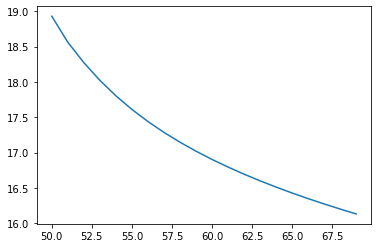

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.show()

Assuming no parameters were changed, you should reach a peak accuracy of 90% at the end of training, which is commendable. Try changing the parameters such as the length of training, and maybe some operations to see how the model behaves. Does it take much longer? How is the performance?

<hr>

## Want to learn more?

Running deep learning programs usually needs a high performance platform. __PowerAI__ speeds up deep learning and AI. Built on IBM’s Power Systems, __PowerAI__ is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The __PowerAI__ platform supports popular machine learning libraries and dependencies including TensorFlow, Caffe, Torch, and Theano. You can use [PowerAI on IMB Cloud](https://cocl.us/ML0120EN_PAI).

Also, you can use __Watson Studio__ to run these notebooks faster with bigger datasets.__Watson Studio__ is IBM’s leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, __Watson Studio__ enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of __Watson Studio__ users today with a free account at [Watson Studio](https://cocl.us/ML0120EN_DSX).This is the end of this lesson. Thank you for reading this notebook, and good luck on your studies.

### Thanks for completing this lesson!

This is the end of **Logistic Regression with TensorFlow** notebook. Hopefully, now you have a deeper understanding of Logistic Regression and how its structure and flow work. Thank you for reading this notebook and good luck on your studies.

Created by: <a href="https://br.linkedin.com/in/walter-gomes-de-amorim-junior-624726121">Saeed Aghabozorgi</a> , <a href="https://br.linkedin.com/in/walter-gomes-de-amorim-junior-624726121">Walter Gomes de Amorim Junior</a> ,  Victor Barros Costa


<hr>

Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).